<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/nice_movie_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import tensorflow as tf
import keras
import time
import numpy as np
from keras.utils import to_categorical
print(tf.__version__)

1.13.1


Using TensorFlow backend.


In [3]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [0]:
data = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')

In [5]:
data = data[~pd.isna(data.overview)]
len(data)

4406

In [6]:
up = 7.3
under = 5

like = data[data.vote_average >= up]
dislike = data[data.vote_average <= under]
neutral = data.loc[(data['vote_average'] > under) & (data['vote_average'] < up )]

print(len(like))
print(len(dislike))
print(len(neutral))

535
442
3429


In [7]:
like.loc[:,'like'] = 1
neutral['like'] = neutral.vote_average.apply(lambda x: 0 if x < 5.9 else 1)
dislike.loc[:,'like'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

In [0]:
data = like.append(dislike)

In [9]:
len(data)

977

In [0]:
import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_comments(x):
    x = normalize(x.lower())
    """x = x.replace('.', ' <PERIOD>')
    x = x.replace(',', ' <COMMA>')
    x = x.replace(';', ' <SEMICOLON>')"""
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº'))
    return x

def delete_stop_words(x):
    words = x.split(" ")
    words = [word for word in words if word not in stop_words]
    x = str(' '.join(words))
    return x


In [11]:

data['overview']=data['overview'].apply(lambda x: clean_comments(str(x)))
data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

neutral['overview']=neutral['overview'].apply(lambda x: clean_comments(str(x)))
neutral['overview']=neutral['overview'].apply(lambda x: delete_stop_words(x))

data


,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,like
3,3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,años batman desaparecio dejando heroe converti...,112.312950,...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,1
6,6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,flynn rider buscado encantador bandido reino e...,48.681969,...,2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,1
7,7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Avengers: Age of Ultron,tony stark reactivar programa caido desuso cuy...,134.279229,...,2015-04-22,1405403694,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,1
8,8,250000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://harrypotter.warnerbros.com/harrypottera...,767,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""n...",en,Harry Potter and the Half-Blood Prince,desastres azotan inglaterra harry compañeros v...,98.885637,...,2009-07-07,933959197,153.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,1
16,16,220000000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",http://marvel.com/avengers_movie/,24428,"[{""id"": 242, ""name"": ""new york""}, {""id"": 5539,...",en,The Avengers,enemigo inesperado surge amenaza seguridad mun...,144.448633,...,2012-04-25,1519557910,143.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Some assembly required.,The Avengers,7.4,11776,1
22,22,250000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.thehobbit.com/,57158,"[{""id"": 603, ""name"": ""elves""}, {""id"": 604, ""na...",en,The Hobbit: The Desolation of Smaug,sobrevivir inicio inesperado viaje compañia ca...,94.370564,...,2013-12-11,958400000,161.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Beyond darkness... beyond desolation... lies t...,The Hobbit: The Desolation of Smaug,7.6,4524,1
25,25,200000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",http://www.titanicmovie.com,597,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298...",en,Titanic,labores recuperacion restos famoso trasatlanti...,100.025899,...,1997-11-18,1845034188,194.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Nothing on Earth could come between them.,Titanic,7.5,7562,1
42,42,200000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/toystory/,10193,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 3616,...",en,Toy Story 3,sabiendo dueño andy niño prepara universidad v...,59.995418,...,2010-06-16,1066969703,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,No toy gets left behind.,Toy Story 3,7.6,4597,1
44,44,190000000,"[{""id"": 28, ""name"": ""Action""}]",http://www.furious7.com/,168259,"[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",en,Furious 7,problemas persiguen librarse mancha criminales...,102.322217,...,2015-04-01,1506249360,137.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Vengeance Hits Home,Furious 7,7.3,4176,1
46,46,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.x-menmovies.co

In [12]:
neutral

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,like
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,año jake sully exmarine condenado vivir silla...,150.437577,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,1
1,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,siguiendo estela sucedido “piratas caribe cofr...,139.082615,...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,1
2,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,criptico mensaje envia james bond mision secre...,107.376788,...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,1
4,4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,adaptacion ‘una princesa marte’ novela fantast...,43.926995,...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,1
5,5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,entrega aventuras joven peter parker maguire p...,115.699814,...,2007-05-01,890871626,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,1
9,9,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.batmanvsupermandawnofjustice.com/,209112,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 7002...",en,Batman v Superman: Dawn of Justice,temor acciones cabo superman vigilante gotham ...,155.790452,...,2016-03-23,873260194,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Justice or revenge,Batman v Superman: Dawn of Justice,5.7,7004,0
10,10,270000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.superman.com,1452,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Superman Returns,años misteriosa ausencia superman regresa tier...,57.925623,...,2006-06-28,391081192,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,NaN,Superman Returns,5.4,1400,0
11,11,200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://www.mgm.com/view/movie/234/Quantum-of-S...,10764,"[{""id"": 627, ""name"": ""killing""}, {""id"": 1568, ...",en,Quantum of Solace,traicionado vesper mujer amaba plantea mision...,107.928811,...,2008-10-30,586090727,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"For love, for hate, for justice, for revenge.",Quantum of Solace,6.1,2965,1
12,12,200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,58,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,will turner elizabeth swann casar hechos prisi...,145.847379,...,2006-06-20,1065659812,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Jack is back!,Pirates of the Caribbean: Dead Man

In [0]:
from sklearn.model_selection import train_test_split

overviews = data['overview'].values
y = data['like'].values

overviews_netutral =  neutral['overview'].values
y_netural = neutral['like'].values

overviews_train, overviews_test, y_train, y_test = train_test_split(overviews, y, test_size=0.1, random_state=777, stratify=y)

In [0]:
columns_train = {'Overview': overviews_train, 'Like': y_train}
train = pd.DataFrame(data=columns_train)
train.to_csv('train' + '.csv', sep=';', encoding='utf-8', index=False)

columns_test = {'Comment': overviews_test, 'Like': y_test}
test = pd.DataFrame(data=columns_test)
test.to_csv('test' + '.csv', sep=';', encoding='utf-8', index=False)

In [0]:
# Embedding
num_words = 10000
maxlen = 70
embedding_size = 1024

# Convolution
kernel_size = 3
filters = 250
pool_size = 2

hidden_dims = 250


# LSTM
lstm_output_size = 70

# Training
lr=0.000008
#lr=0.000003

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(overviews_train)

X_train = tokenizer.texts_to_sequences(overviews_train) 
X_test = tokenizer.texts_to_sequences(overviews_test)
X_neutral = tokenizer.texts_to_sequences(overviews_netutral)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

print(overviews_train[2]) 
print(X_train[2]) 
print(vocab_size)

narra historia familia seed ambientada marcha oeste mormones divididos reacciones diversas ideologia steed tratan mantenerse unidos firmes convicciones sintiendose constantemente puestos prueba fe perseguida norteamerica siglo xix
[68, 5, 6, 2705, 507, 584, 383, 4593, 4594, 1838, 1348, 4595, 4596, 1050, 4597, 31, 4598, 4599, 4600, 2706, 1049, 172, 1051, 2707, 4601, 78, 1349]
11180


In [17]:
from collections import OrderedDict

dictWords = dict(tokenizer.word_counts)

print(len(dictWords) + 1)

for k,v in list(dictWords.items()):
    if v < 2 :
        del dictWords[k]
        
print(len(dictWords) + 1) 
# Para establecer el tamaño de maxlen

len(max(X_train, key=len))

11180
4576


81

In [18]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_neutral = pad_sequences(X_neutral, padding='post', maxlen=maxlen)

X_train[1]

array([1344,   30,    9, 4582, 2700, 2701, 2702,  710, 4583, 4584, 4585,
       1048,  332,  429,  583,  429,  382, 1345, 2703, 4586, 1346, 1836,
       1345, 1347,   36,   54, 4587, 4588,  227, 1049,  186, 1837,  506,
        283, 4589, 2704,  430, 4590, 4591,  429, 4592,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [0]:
from keras import backend as K
from keras.callbacks import EarlyStopping

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[0]
    K.get_session().run(tf.local_variables_initializer())
    return auc

#Optimizer

from keras import optimizers

adam = optimizers.Adam(lr)


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=20,
                   verbose=0, mode='auto')

In [21]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

#class_weights[1] = class_weights[1] * 3
class_weights

array([1.10427136, 0.91372141])

In [22]:
# Model 1

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, GlobalMaxPool1D

model = Sequential()

model.add(Embedding(vocab_size,embedding_size, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['acc',precision,recall])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 2048)          22896640  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
___________________________

In [33]:
# Model 2


from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(vocab_size,
                    embedding_size,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy',precision])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 1024)          11448320  
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 1024)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 68, 250)           768250    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               62750     
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
__________

In [0]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32, callbacks=[es], class_weight = class_weights)

Train on 879 samples, validate on 98 samples
Epoch 1/500
879/879 [==============================] - 2s 2ms/step - loss: 0.6938 - acc: 0.4801 - precision: 0.5139 - val_loss: 0.6926 - val_acc: 0.5000 - val_precision: 0.5275
Epoch 2/500
879/879 [==============================] - 1s 887us/step - loss: 0.6915 - acc: 0.5506 - precision: 0.5504 - val_loss: 0.6914 - val_acc: 0.5408 - val_precision: 0.5474
Epoch 3/500
879/879 [==============================] - 1s 877us/step - loss: 0.6887 - acc: 0.5472 - precision: 0.5472 - val_loss: 0.6902 - val_acc: 0.5510 - val_precision: 0.5510
Epoch 4/500
879/879 [==============================] - 1s 875us/step - loss: 0.6877 - acc: 0.5472 - precision: 0.5472 - val_loss: 0.6894 - val_acc: 0.5510 - val_precision: 0.5510
Epoch 5/500
879/879 [==============================] - 1s 882us/step - loss: 0.6860 - acc: 0.5472 - precision: 0.5472 - val_loss: 0.6887 - val_acc: 0.5510 - val_precision: 0.5510
Epoch 6/500
879/879 [==============================] - 1s 882u

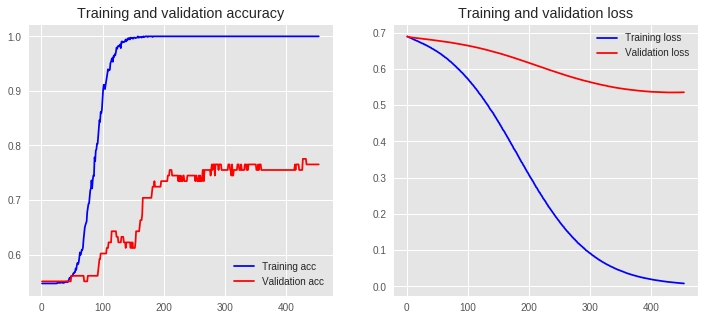

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [29]:
y_pred = model.predict_classes(X_test)
y_score = model.predict(X_test)
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

"""for idx,p in enumerate(y_score):
    if p >= 0.5:
        y_pred[idx] = 1
    else:
        y_pred[idx] = 0"""

'for idx,p in enumerate(y_score):\n    if p >= 0.5:\n        y_pred[idx] = 1\n    else:\n        y_pred[idx] = 0'

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[32 12]
 [11 43]]
Accuracy: 0.7653
Kappa: 0.5247
Precision: 0.7818
Recall: 0.7963
F1: 0.7890
Auc: 0.7618


In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)